#Analyzing NYC subway data

This project look at the NYC Subway data and figure out if more people ride the subway when it is raining versus when it is not raining.

The data can be found at:

* Original data set at: https://www.dropbox.com/s/meyki2wl9xfa7yk/turnstile_data_master_with_weather.csv
* Improved data set at: https://www.dropbox.com/s/1lpoeh2w6px4diu/improved-dataset.zip?dl=0

---

## References

* Frost, Jim. Choosing Between a Nonparametric Test and a Parametric Test. http://blog.minitab.com/blog/adventures-in-statistics/choosing-between-a-nonparametric-test-and-a-parametric-test
* SPSS tutorial. Mann-Whitney U Test using SPS. https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics.php
* Frost, Jim. Regression Analysis: How Do I Interpret R-squared and Assess the Goodness-of-Fit? http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit
* NIST. Are the model residuals well-behaved? http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm
* OriginLab. Graphic Residual Analysis. http://www.originlab.com/doc/Origin-Help/Residual-Plot-Analysis
* Graphpad. One-tail vs. two-tail P values. http://graphpad.com/guides/prism/6/statistics/index.htm?one-tail_vs__two-tail_p_values.htm
* Skymark.com. Normal Test Plot. http://www.skymark.com/resources/tools/normal_test_plot.asp
* Nau, Robert. Regression diagnostics:  testing the assumptions of linear regression. http://people.duke.edu/~rnau/testing.htm

---

## Statistical Analysis

In [1]:
%matplotlib inline

import numpy as np
import pandas
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    
    sns.set_palette("deep", desat=.6)
    sns.set_context(rc={"figure.figsize": (10, 6)})
except ImportError:
    sns = None

In [2]:
df = pandas.read_csv('turnstile_data_master_with_weather.csv')

I split up the data into two category, with rain and without rain.
I then summarize and plot the distribution for this two samples.

In [3]:
with_rain_df = df['ENTRIESn_hourly'][df['rain'] == 1]
without_rain_df = df['ENTRIESn_hourly'][df['rain'] == 0]

# Let's take a look at the summary of these two samples
summary = pandas.concat([with_rain_df.describe(), without_rain_df.describe()], axis=1)
summary.columns = ['With rain summary', 'Without rain summary']

print summary

       With rain summary  Without rain summary
count       44104.000000          87847.000000
mean         1105.446377           1090.278780
std          2370.527674           2320.004938
min             0.000000              0.000000
25%            41.000000             38.000000
50%           282.000000            278.000000
75%          1103.250000           1111.000000
max         51839.000000          43199.000000


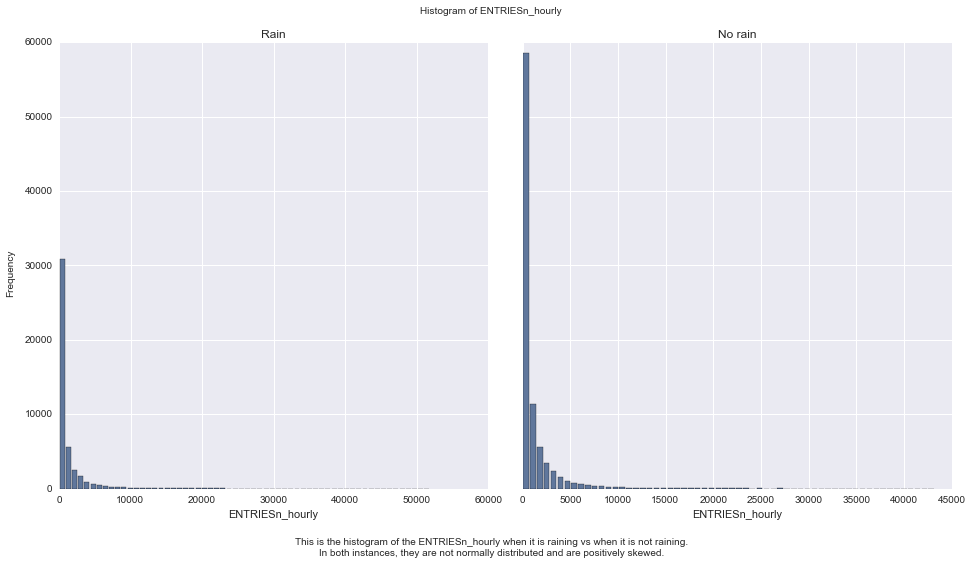

In [4]:
plot_description = ('This is the histogram of the ENTRIESn_hourly when it is raining vs when it is not raining.\n'
                    'In both instances, they are not normally distributed and are positively skewed.')

figure, plot_list = plt.subplots(1, 2, sharey=True, figsize=(16, 8))
figure.subplots_adjust(wspace=0.08)
figure.text(0.08, 0.5, 'Frequency', va='center', rotation='vertical')
figure.text(0.5, 0.95, 'Histogram of ENTRIESn_hourly', ha='center')
figure.text(0.5, 0.01, plot_description, ha='center')

df_list = [(with_rain_df, 'Rain'), (without_rain_df, 'No rain')]

for idx, plot in enumerate(plot_list):
    hist, bins = np.histogram(df_list[idx][0], bins=60)
    width = 0.8 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plot.bar(center, hist, align='center', width=width)
    plot.set_title(df_list[idx][1])
    plot.set_xlabel('ENTRIESn_hourly')

### Statistical test, tail and null hypothesis

I perform Mann-Whitney U test on the two samples. We will be performing a two-tail P value with .05 p-critical value, with the following hypothesis:

*The null hypothesis is:*

The distributions of both groups are identical, so that there is a 50% probability that an observation from a value randomly selected from one population exceeds an observation randomly selected from the other population.

P(x > y) = 0.5

*Alternative hypothesis:*

The distributions of both groups are not identical, the probability that an observation from a value randomly selected from one population exceeds an observation randomly selected from the other population is not 50%.

P(x > y) != 0.5 


### Statistical test reasoning
I am using this test because the samples is non-normal.
Generally, we use Mann-Whitney U test, if it follow several assumptions:

* The dependent variable is ordinal or continous
* The independent variable (with rain, without rain) is 2 categorical data
* There is no relationship between the observations in each group or between the groups themselves
* The two variables are not normaly distributed

### Result
Below the computed result:

In [5]:
import scipy.stats

U, p = scipy.stats.mannwhitneyu(with_rain_df, without_rain_df)
print "U :", U
print "two-tail p :", p * 2  # the module returns one-tail value, we need to multiply by 2 to get two-tail value

U : 1924409167.0
two-tail p : 0.049999825587


We can see that the p < .05.

### Interpretation

Since our p-value of 0.049999825587 is < 0.05 our critical value.
We conclude that there is statistically significant difference between the distributions of the two sample. This results are significant at the .05 level.

---

## Linear Regression

Now let's build a model so we can make predictions.

### Approach
To compute the coefficients theta and produce prediction for ENTRIESn_hourly in the regression model I choose to 
use OLS using Statsmodels.

I added 3 helper function here:

* A function that does linear regression,
* A function that calculate R^2. We need this to check on our result and,
* A function that generate list of prediction value based on data and list of features

In [5]:
import statsmodels.api as sm

def linear_regression(features, values):
    """
    Perform linear regression given a data set with an arbitrary number of features.
    """    
    features = sm.add_constant(features)
    model = sm.OLS(values, features)
    results = model.fit()
    
    intercept, params = results.params[0], results.params[1:]
    return intercept, params

def compute_r_squared(data, predictions):
    '''
    Compute r_squared given a data set and the predictions.
    '''
    
    data_mean = np.mean(data)
    ss_res = ((data - predictions)**2).sum()
    ss_tot = ((data - data_mean)**2).sum()
    r_squared = 1 - (ss_res/ss_tot)
    
    return r_squared

def calculate_predictions(dataframe, features):
    '''
    Generate prediction given dataframe and features.
    '''
    
    # Add UNIT to features using dummy variables
    dummy_units = pandas.get_dummies(dataframe['UNIT'], prefix='unit')
    features = features.join(dummy_units)

    # Values
    values = dataframe['ENTRIESn_hourly']

    # Get the numpy arrays
    features_array = features.values
    values_array = values.values

    # Perform linear regression
    intercept, params = linear_regression(features_array, values_array)

    predictions = intercept + np.dot(features_array, params)

    return predictions, intercept, params

### Features

I will try to compute the prediction for several possible features.
Please check the code below for the features.
I aim to have R^2 score of 0.40 or better.

The features of interest are listed below along with the reason:
 
* rain : I think people will decide to ride the subway if it is raining
* precipi : same with the above, it includes snow, drizzle, hail, etc.
* meantempi : I think people will ride the subway more if it is cold
* fog : I think people will ride the subway more if it is fogging, it is probably not fun to drive
* meanwindspi: If it is windy, people who use bike or walk might opt to take subway
* Hour : People tend to ride subway on certain hour, for example to get to or back from work. 

I will create combinations out of these feature, compute the predictions and get the R^2 value.

In addition to this, I have added dummy variables 'UNIT' for the features.

In [6]:
from itertools import combinations

# Build our features list combination
feature_of_interest = ['rain', 'meantempi', 'fog', 'meanwindspdi', 'precipi', 'Hour']
features_list = []
for count in range(1, len(feature_of_interest) + 1):
    for item in combinations(feature_of_interest, count):
        features_list.append(list(item))

best_score = {'score': 0}
for features in features_list:
    predictions, intercept, params = calculate_predictions(df, df[features])
    r2_score = compute_r_squared(df['ENTRIESn_hourly'], predictions)

    # Save the best score
    if r2_score > best_score['score']:
        best_score['score'] = r2_score
        best_score['feature_variables'] =  features
        best_score['intercept'] = intercept
        best_score['param'] = params
        best_score['predictions_values'] =  predictions

print "\n\n"
print "The highest score :", best_score['score']
print "Feature variables for the highest score:", ', '.join(best_score['feature_variables'])
print "Coefficient for the highest score"
print "             Intercept:", best_score['intercept']
print "  Non-dummy Parameters:", best_score['param'][:len(best_score['feature_variables'])]




The highest score : 0.419410016672
Feature variables for the highest score: rain, meantempi, fog, meanwindspdi, precipi
Coefficient for the highest score
             Intercept: 1800.0574922
  Non-dummy Parameters: [ -32.42166508   -6.00266743  121.67833802   26.07689552  -25.4362554 ]


### Results

The features variables we use :
**rain, meantempi, fog, meanwindspdi, precipi, Hour**

The parameters of the non-dummy features are:
**-32.26725174, -5.91215877, 120.27580878, 26.27992382, -22.61805652, 67.39739472**

The R2 value is **0.458621326664**

### Intrepretation

In order to see the goodness of fit for the regression model, let's try to plot the residuals
(that is, the difference between the original hourly entry data and the predicted values).

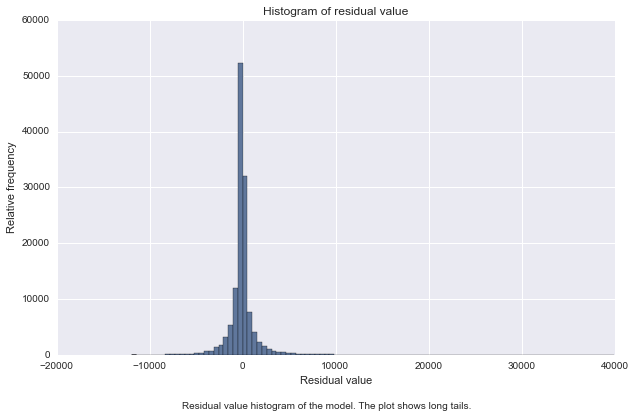

In [7]:
figure = plt.figure()
plt.title('Histogram of residual value')
plt.xlabel('Residual value')
plt.ylabel('Relative frequency')

(df['ENTRIESn_hourly'] - best_score['predictions_values']).hist(bins=100)

plot_description = 'Residual value histogram of the model. The plot shows long tails.'
figure.text(0.5, 0, plot_description, ha='center')


The histogram has long tails, which suggests that there are some very large residuals. To make sure I plot normal probably plot.

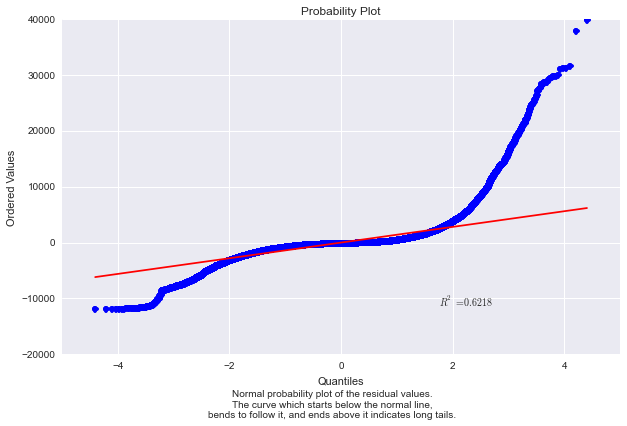

In [8]:
import scipy.stats

figure = plt.figure()
prob_plot = scipy.stats.probplot(df['ENTRIESn_hourly'] - best_score['predictions_values'], plot=plt)

plot_description = ('Normal probability plot of the residual values.\n'
                    'The curve which starts below the normal line,\n'
                    'bends to follow it, and ends above it indicates long tails.')
figure.text(0.5, -0.02, plot_description, ha='center')

The plot confirms that we have long tails problem which means we are seeing more variance than we would expect in a normal distribution.

In fact if we simply plot the residual values we got:

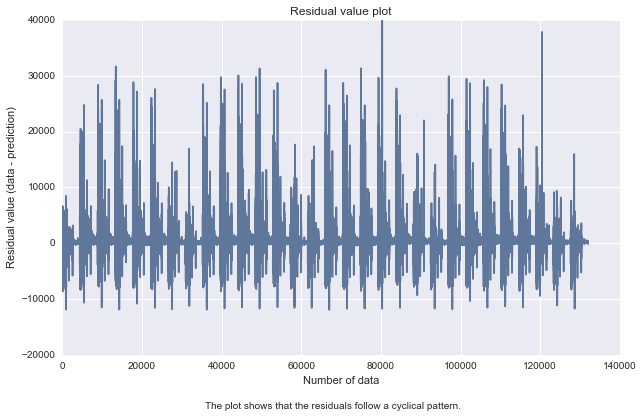

In [9]:
figure = plt.figure()
plt.title('Residual value plot')
plt.xlabel('Number of data')
plt.ylabel('Residual value (data - prediction)')

plt.plot(df['ENTRIESn_hourly'] - best_score['predictions_values']) 

plot_description = 'The plot shows that the residuals follow a cyclical pattern.'
figure.text(0.5, 0, plot_description, ha='center')

It shows that there are some non-linearity in the data.
And this should be addressed by designing a non linear model.

In conclusion, we achieve a R^2 value that we set (> 0.40), but on further inspection we find out that the linear model is **not** appropriate to predict ridership.


## Visualization

Let's use some visualization to ask get some more answer from the data.

First, let's see ridership by day of week.

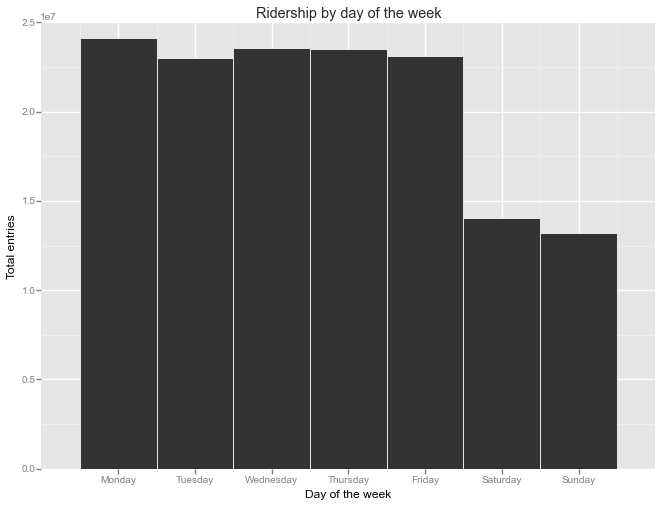

<ggplot: (284688877)>


In [10]:
import datetime
from ggplot import *

df_with_weekday = df.copy()
df_with_weekday['weekday'] = df_with_weekday['DATEn'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').weekday())

days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df_with_weekday = df_with_weekday[['weekday', 'ENTRIESn_hourly', 'EXITSn_hourly']].groupby('weekday').sum().reset_index()
plot = ggplot(aes(x='weekday'), data=df_with_weekday) + \
         geom_bar(aes(x='weekday', y='ENTRIESn_hourly'), stat='bar') + \
         xlab('Day of the week') + \
         ylab('Total entries') + \
         scale_x_continuous(breaks=range(7), labels=days) + \
         ggtitle('Ridership by day of the week')
         
print plot

Now, let's try to see the top 20 station with the highest total entry.

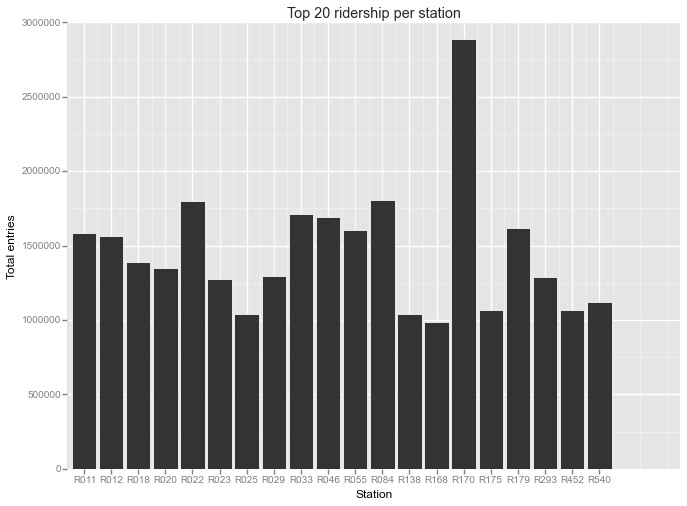

<ggplot: (288977293)>


In [10]:
unit_entries_df = df[['UNIT', 'ENTRIESn_hourly']].groupby(['UNIT']).sum().sort(['ENTRIESn_hourly'], ascending =[0]).reset_index()[:20]
plot= ggplot(aes(x='UNIT', y='ENTRIESn_hourly'), data=unit_entries_df) + \
         geom_bar(aes(x='UNIT', weight='ENTRIESn_hourly'), stat='bar') + \
         xlab('Station') + \
         ylab('Total entries') + \
         ggtitle('Top 20 ridership per station')
    
print plot

Another visualization. This time using matplotlib.
Showing total ridership by week day and hour.

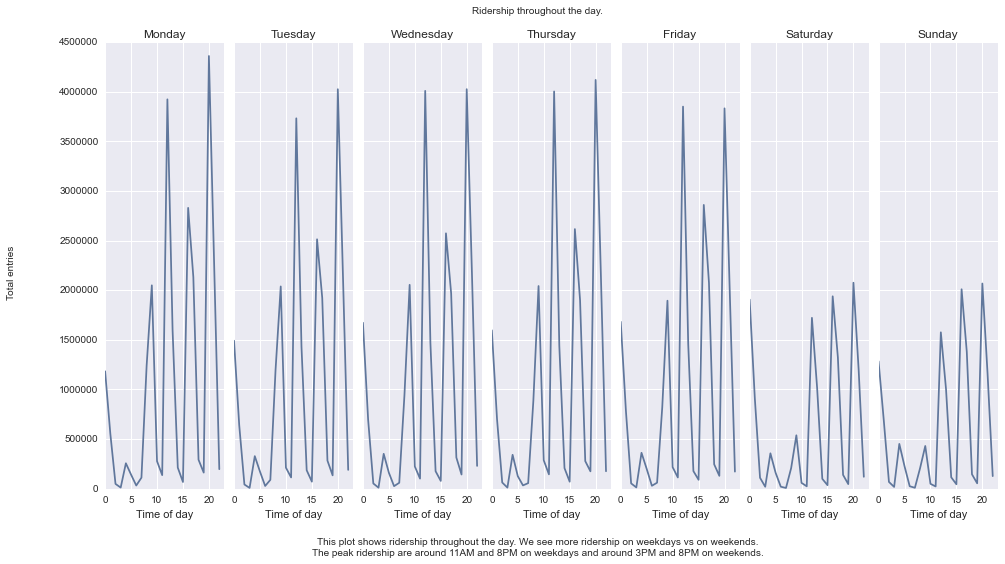

In [15]:
df_with_weekday = df.copy()
df_with_weekday['weekday'] = df_with_weekday['DATEn'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').weekday())

weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

figure, plot_list = plt.subplots(1, 7, sharey=True, figsize=(16, 8))
figure.text(0.04, 0.5, 'Total entries', va='center', rotation='vertical')
figure.text(0.5, 0.95, 'Ridership throughout the day.', ha='center')
figure.subplots_adjust(wspace=0.08)
for day, item in enumerate(plot_list):
    total_per_hour = []
    for i in range(23):
        total_per_hour.append(df_with_weekday['ENTRIESn_hourly'][(df_with_weekday['weekday'] == day) & (df_with_weekday['Hour'] == i)].sum())
    item.plot(range(23), total_per_hour)
    item.set_xlim(0, 23)
    item.set_xlabel('Time of day')
    item.set_title(weekday[day])
    
plot_description = ('This plot shows ridership throughout the day. We see more ridership on weekdays vs on weekends.\n'
                    'The peak ridership are around 11AM and 8PM on weekdays and around 3PM and 8PM on weekends.')
figure.text(0.5, 0.01, plot_description, ha='center')

Looks like there is more entry on weekdays versus on weekends. And it is pretty similar routine on weekdays.
A peak at around 10AM and another one around 8PM.

---

## Conclusions

Our statistical analysis shows that there is significant difference in ridership when it is raining vs when it is not raining.

We develop a model to predict the ridership. We used linear model (OLS) and achieve R^2 value that we set as the goal. However after analyzing the residual, we find that the model is not appropriate to predict the ridership. 

---

## Reflection

### Analysis

We used linear regression method to make our models. But the resulting model does not seems to be appropriate to predict the ridership of NYC subway. We need to address the non-linearity in the data. 

Initially I thought maybe if I remove the Hour from the model features list (looking at figure 3.2 I conclude that this is what causes the cycle) the model will work, but I got the same result.

### Dataset

The dataset although big (131951) only covers a month of data.
This is probably not enough. 

In [7]:
print df['DATEn'].min()
print df['DATEn'].max()

2011-05-01
2011-05-30
